In [1]:
library(Seurat)
library(SeuratObject)
library(dplyr)
library(ggplot2)

genelist <- readRDS(file = paste0("./load_files/Bulk_DEseq2_genes_v2.rds"))
load(file = "./load_files/InVivo_seurat_data_v3.Rdata") ## early, late


Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
table(early$subtype, early$region)

                      
                         FC   OC
  ExN CUX2 ACTN2         53   26
  ExN CUX2 ADRA2A      1986  526
  ExN CUX2 PALMD        590  182
  ExN SOX5 ID2         1781 3365
  ExN SOX5 KCNV1        224   53
  ExN SOX5 NR4A2 GRID2  923 1794
  ExN SOX5 PALMD       4476 7624
  ExN SOX5 SYT6        1711 5581
  IPC EOMES NEUROG1    2431 4940
  IPC EOMES NHLH1 deep 1493 3113
  IPC EOMES NHLH1 up    401  257
  IPC EOMES VIM         367 1036
  NESC RSPO3 DIRAS3      80  392
  NESC RSPO3 TEX15      382  701
  oRG HOPX TNC            3    0
  RGC FABP7 PMP22       524   16
  vRG HMGA2 CCND1      3034 4193
  vRG SAT1 STMN2          8   25

In [3]:
## Set some parameters
xaxis_limits <- c(-0.9, 0.9)
yaxis_limits <- c(0, 60)

In [4]:
## Functions used in this analysis

## Functions to do in vivo DE
FindRegionMarkers <- function(object, x_range = c(-0.9, 0.9), y_range = c(0, 40)){
    Idents(object) <- "region"
    ## only.pos has to be set to FALSE, so that the genes of res1 and res2 are the same
    ## Also, it can gives both negative and positive FCs
    res1 <- FindMarkers(object, ident.1 = "FC", ident.2 = "OC", 
                        max.cells.per.ident = 1000, only.pos = FALSE, 
                        features = genes, min.pct = -1, logfc.threshold = -1)

    res2 <- FindMarkers(object, ident.1 = "OC", ident.2 = "FC", 
                        max.cells.per.ident = 1000, only.pos = FALSE, 
                        features = genes, min.pct = -1, logfc.threshold = -1)
    
    ## check the consistency of genes
    if (length(setdiff(rownames(res1), rownames(res2))) > 0 | length(setdiff(rownames(res2), rownames(res1))) > 0){
        stop("The genes in res1 and res2 are not the same")
    }
    
    res2 <- res2[rownames(res1), , drop = FALSE]

    df <- data.frame(gene = rownames(res1),
                    pct.fc = res1$pct.1,
                    pct.oc = res1$pct.2,
                    p_val_adj = res1$p_val_adj,
                    log2fc.fc = res1$avg_log2FC,
                    log2fc.oc = res2$avg_log2FC,
                    stringsAsFactors = FALSE)
    
    df <- df %>%
                    mutate(log2fc.fc = MinMax(log2fc.fc, min = x_range[1], max = x_range[2])) %>%
                    mutate(mlogp = -log10(p_val_adj)) %>%
                    mutate(mlogp = MinMax(mlogp, min = y_range[1], max = y_range[2]))
    return(df)
}

PlotDot <- function(data, frontal_label, occipital_label, x_range = c(-0.9, 0.9), y_range = c(0, 60)){
    ## preprocess the data based on the labeled genes
    data$gtype <- sapply(data$gene, function(x) 
                            case_when(x %in% frontal_label ~ "FC",
                                        x %in% occipital_label ~ "OC",
                                        TRUE ~ "bg")
                            )
    data$color <- c(FC = "#FF420E", OC = "#89DA59", bg = "#D3D3D3")[data$gtype]
    data$size <- c(FC = 4, OC = 4, bg = 2)[data$gtype]
    data$label <- ifelse(data$gene %in% union(frontal_label, occipital_label), data$gene, NA)
    print(filter(data, gene %in% "CBLN2"))

    set.seed(42)
    p <- ggplot(data, aes(x = log2fc.fc, y = mlogp, color = color, size = size, label = label)) +
                ggrastr::rasterise(geom_point(alpha = 0.7, shape = 16), dpi = 300, scale = 1) +
                ggrepel::geom_text_repel(max.overlaps = Inf) +
                geom_hline(yintercept = -log10(0.05), linetype = "dashed", linewidth = 1) +
                scale_color_identity() +
                scale_size_identity() +
                scale_x_continuous(limits = x_range) +
                scale_y_continuous(limits = y_range) +
                theme_bw() +
                theme(panel.grid.major = element_blank(), 
                      panel.grid.minor = element_blank(), 
                      legend.position = "none")
    return(p)
}

In [5]:
## Load the type-2 genes (only region-specific in the late stage of the in vitro development)
## and Check their in vivo regional enrichment of all these genes
ag <- "E42"
type2_genes <- lapply(c("FC", "OC"), function(reg) {
    reg_late <- setdiff(genelist[[paste0(ag, "_", reg, "_late")]], genelist[[paste0(ag, "_", reg, "_early")]])
    return(reg_late)
    }) %>%
    setNames(., c("FC", "OC"))
type2_genes %>% lapply(., function(x) head(x, 50))

$FC
 [1] "DHRS3"    "ITGA8"    "GJA1"     "CMBL"     "GPRC5B"   "LRRC17"  
 [7] "ZBTB7C"   "SLC6A9"   "CPT1A"    "SULT1E1"  "CALB2"    "FBLN1"   
[13] "PDGFRA"   "MMP17"    "NHS"      "GPC6"     "GSX1"     "CAMK1D"  
[19] "PTK7"     "ARHGAP31" "MAN1C1"   "PSAT1"    "YBX3"     "JAM3"    
[25] "TMEM100"  "WFIKKN2"  "TNFRSF19" "SRPX2"    "KDR"      "FAM43A"  
[31] "SMAD3"    "ANKRD33B" "ZIC2"     "SLC16A9"  "AJAP1"    "MDK"     
[37] "RBP1"     "NPC2"     "CRTAC1"   "FUCA1"    "CREB3L2"  "NUCB1"   
[43] "DPF3"     "COL27A1"  "PHACTR2"  "B2M"      "ATP1A2"   "EYA2"    
[49] "SPOCK2"   "EFNA5"   

$OC
 [1] "LOC114671387" "NEUROD6"      "SATB2"        "SLA"          "TBR1"        
 [6] "ZBTB18"       "NEUROD2"      "NRN1"         "CHL1"         "LOC694442"   
[11] "LOC107000617" "RNF182"       "SHISAL1"      "PRDM8"        "HES6"        
[16] "LOC106992821" "IL33"         "MN1"          "LRRC7"        "LINGO1"      
[21] "GRIA2"        "SLC17A6"      "TMEM132B"     "LRP8"         "SORCS3"      
[26] "PLXNA4"       "CHRDL1"       "LOC106999282" "PPFIA2"       "MAPK11"      
[31] "GAP43"        "LOC696885"    "HAS2"         "CARMIL3"      "LOC114676844"
[36] "CACNA2D1"     "CRHR1"        "TRIM2"        "SLC1A2"       "TMEM108"     
[41] "CRYAB"        "KLHL29"       "GPM6A"        "SOX11"        "RASGRP1"     
[46] "CTTNBP2"      "SMPD3"        "FBXW7"        "ADRA2A"       "NRBP2"

In [6]:
## Check the in vivo regional enrichment of all these invitro late genes
genes <- unlist(type2_genes) %>% unique() %>%
            intersect(., rownames(early))

early$subcls_abbr <- early$subclass
early$subcls_abbr[early$subtype %in% "ExN SOX5 NR4A2 GRID2"] <- "L6B"
early$subcls_abbr[early$subtype %in% "ExN SOX5 PALMD"] <- "deepNas"
early$subcls_abbr[early$subtype %in% "ExN SOX5 SYT6"] <- "L6CT"
table(early$subcls_abbr, early$region)

                    
                       FC   OC
  deepNas            4476 7624
  dorsal NSC         4031 5327
  enIPC              4692 9346
  Excitatory neurons 4634 4152
  L6B                 923 1794
  L6CT               1711 5581

In [7]:
##"deepNas", 
deres <- lapply(c("L6B", "L6CT"), function(cls){
    df <- FindRegionMarkers(object = subset(early, subcls_abbr %in% cls),
                           x_range = xaxis_limits, y_range = yaxis_limits) %>%
            mutate(cluster = cls)
    return(df)
    }) %>%
    setNames(., c("L6B", "L6CT"))
lapply(deres, head, 3)

,gene,pct.fc,pct.oc,p_val_adj,log2fc.fc,log2fc.oc,mlogp,cluster
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,CLMP,0.377,0.014,8.823010e-84,0.6633701,-0.6633701,60.0000,L6B
2,SATB2,0.382,0.040,2.072151e-73,0.6601777,-0.6601777,60.0000,L6B
3,CHL1,0.613,0.230,4.392392e-54,0.5875482,-0.5875482,53.3573,L6B
,gene,pct.fc,pct.oc,p_val_adj,log2fc.fc,log2fc.oc,mlogp,cluster
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,SATB2,0.455,0.013,3.231424e-114,0.8507029,-0.8507029,60,L6CT
2,CHL1,0.519,0.073,2.482404e-93,0.7618009,-0.7618009,60,L6CT
3,RORB,0.440,0.066,4.410415e-79,0.6503950,-0.6503950,60,L6CT


   gene pct.fc pct.oc p_val_adj  log2fc.fc   log2fc.oc mlogp cluster gtype
1 CBLN2  0.008      0         1 0.01660803 -0.01660803     0     L6B    bg
    color size label
1 #D3D3D3    2  <NA>
   gene pct.fc pct.oc p_val_adj  log2fc.fc   log2fc.oc mlogp cluster gtype
1 CBLN2  0.026      0         1 0.05805492 -0.05805492     0    L6CT    bg
    color size label
1 #D3D3D3    2  <NA>


Warning message:
“Removed 972 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 968 rows containing missing values (`geom_text_repel()`).”


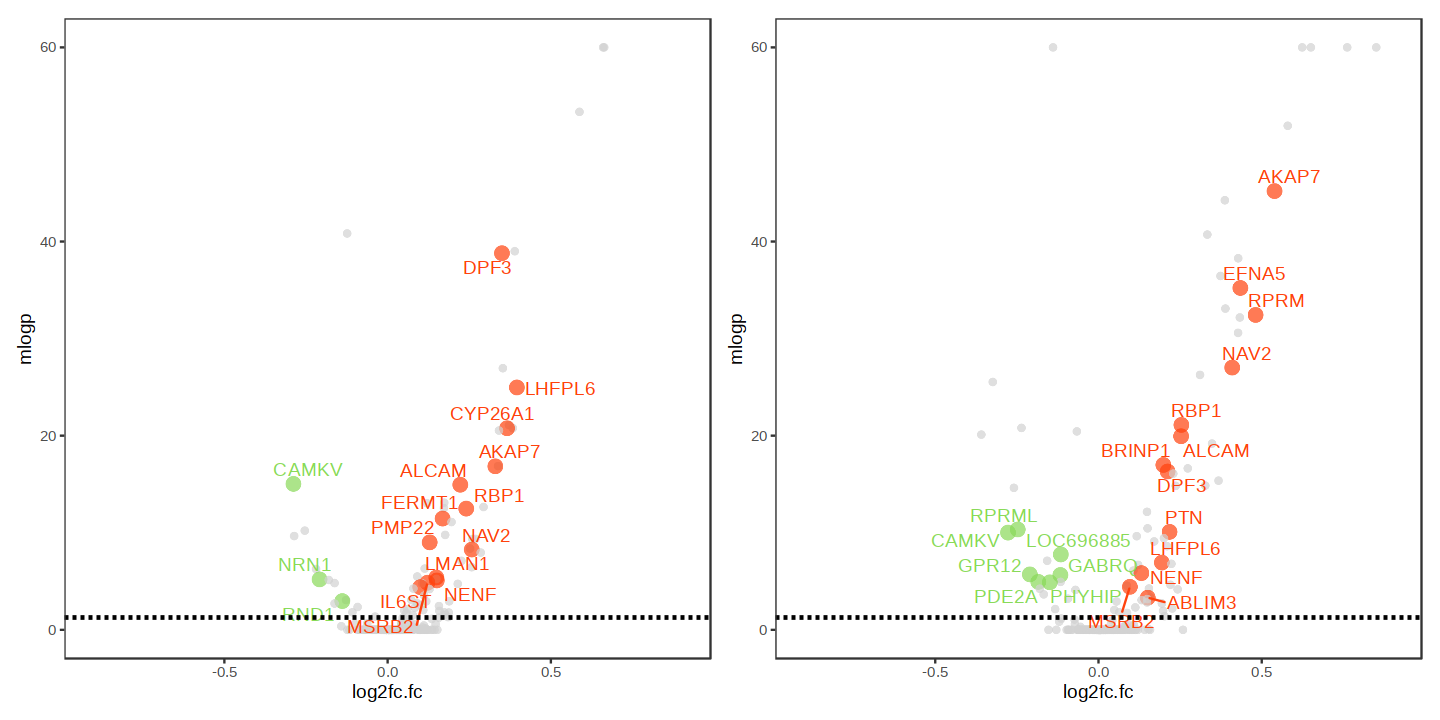

In [8]:
## volcano plot for early cells
##"deepNas", 
plist1 <- lapply(c("L6B", "L6CT"), function(cls){
    subres <- deres[[cls]]
    ## region-specific genes to be labeled (show enrichment in vivo & also present as type2 genes in vitro)
    fc_label <- subres$gene[subres$p_val_adj <= 0.05 & subres$pct.fc >= 0.05 & subres$log2fc.fc > 0] %>% 
                    unique() %>%
                    intersect(., type2_genes[["FC"]])
    oc_label <- subres$gene[subres$p_val_adj <= 0.05 & subres$pct.oc >= 0.05 & subres$log2fc.oc > 0] %>% 
                    unique() %>%
                    intersect(., type2_genes[["OC"]])

    p <- PlotDot(data = subres, frontal_label = fc_label, occipital_label = oc_label,
                x_range = xaxis_limits, y_range = yaxis_limits)
    return(p)
    })
newp1 <- patchwork::wrap_plots(plist1, nrow = 1, ncol = length(plist1))
options(repr.plot.width=12, repr.plot.height=6)
newp1

In [9]:
## Validate the results in vitro
load(file = paste0("./load_files/NSC_invitro_dorsal_bulk_RNA.Rdata"))
## subcount, subrpkm, submeta
logrpkm <- log2(subrpkm + 1)
submeta$period <- sapply(submeta$days, function(x){
    p <- case_when(x <= 3 ~ "early", 
                    x >3 & x < 8 ~ "mid",
                    x >= 8 ~ "late")
    return(p)
    })



fc.points <- rownames(submeta)[submeta$age %in% ag & 
                               submeta$period %in% "late" & 
                               submeta$region %in% "FC"]
oc.points <- rownames(submeta)[submeta$age %in% ag & 
                               submeta$period %in% "late" & 
                               submeta$region %in% "OC"]
## inconsistent regional enrichment between in vitro and in vivo
subrpkm[c("DPF3", "CYP26A1", "ALCAM", "CAMKV", "RPRML", "NRN1"), c(fc.points, oc.points)] 

,RM_8F_42,RM_9F_42,RM_8C_42,RM_9C_42
DPF3,17.2883,17.8498,5.6357,6.9699
CYP26A1,1.4578,1.1203,0.1158,0.0316
ALCAM,31.1135,43.5353,9.1490,11.2410
CAMKV,5.6610,5.2507,14.6090,18.6405
RPRML,0.0385,0.1170,0.4087,0.5718
NRN1,1.9221,2.1627,17.6937,15.8590


In [10]:
#pdf(paste0("./report/Show_BulkDEG_in_vivo_", ag, "_volcano_v2.pdf"), 
#        width = 4 * length(plist1), height = 4, useDingbats = FALSE)
#print(newp1)
#dev.off()

In [11]:
## Visualization for the late cells
ag <- "E77"
type2_genes <- lapply(c("FC", "OC"), function(reg) {
    reg_late <- setdiff(genelist[[paste0(ag, "_", reg, "_late")]], genelist[[paste0(ag, "_", reg, "_early")]])
    return(reg_late)
    }) %>%
    setNames(., c("FC", "OC"))
type2_genes %>% lapply(., function(x) head(x, 50))


$FC
 [1] "PLXDC1"     "HCN1"       "SPP1"       "BTBD11"     "THBS1"     
 [6] "SPARC"      "BHLHE40"    "HLF"        "CRISPLD1"   "LRFN2"     
[11] "CBLN2"      "SELENOP"    "CNR1"       "CFI"        "EPHA2"     
[16] "LHFPL6"     "FGD6"       "CPNE6"      "FRMD7"      "DSG2"      
[21] "UNC5D"      "ALS2CL"     "NEUROD2"    "USH1G"      "COL16A1"   
[26] "VAV3"       "SNCA"       "NECAB1"     "CLMP"       "NUAK2"     
[31] "KCNH5"      "PITPNM1"    "ABCA8"      "SLCO5A1"    "TBR1"      
[36] "KDELR3"     "CDH22"      "CACNG5"     "SRPX2"      "TNFRSF10D" 
[41] "ADRA2A"     "COL2A1"     "ST6GALNAC2" "TNFAIP2"    "HHAT"      
[46] "EFNA5"      "TMEM176A"   "CFH"        "CDH12"      "CALB2"     

$OC
 [1] "CHRNE"        "THRB"         "AJAP1"        "PDGFRA"       "ADCY1"       
 [6] "LPAR1"        "COLCA2"       "ETS2"         "PIP5K1B"      "GABRE"       
[11] "VSTM2B"       "PDZD2"        "MAL"          "LPCAT1"       "ZBTB16"      
[16] "KCNQ4"        "LPA"          "CHST9"        "CA12"         "STUM"        
[21] "LOC114674432" "COL9A1"       "EFHD1"        "SNCB"         "DAAM2"       
[26] "LOC106992461" "GAL"          "DLL1"         "DHRS3"        "LOC723542"   
[31] "ACAN"         "NT5E"         "TMEM178A"     "ALDOC"        "GALNT16"     
[36] "MMRN2"        "TSHZ2"        "TNC"          "NCALD"        "ST3GAL1"     
[41] "BMPER"        "LOC715706"    "TMEM132D"     "GLT1D1"       "PTPRE"       
[46] "PPFIA3"       "AGT"          "EYA1"         "LOC716041"    "LOC100427524"

In [12]:
sapply(genelist, function(x) "CBLN2" %in% x)

E42_FC_early  E42_FC_late   E42_FC_mid E42_OC_early  E42_OC_late   E42_OC_mid 
       FALSE         TRUE        FALSE        FALSE        FALSE        FALSE 
E77_FC_early  E77_FC_late   E77_FC_mid E77_OC_early  E77_OC_late   E77_OC_mid 
       FALSE         TRUE         TRUE        FALSE        FALSE        FALSE

In [13]:
table(late$subtype, late$region)

                      
                         FC   OC
  Ependymal FOXJ1         2    0
  ExN CUX2 ACTN2       1029 6831
  ExN CUX2 ADRA2A      2469 4691
  ExN CUX2 PALMD       1623 6099
  ExN SOX5 NR4A2 GRID2   15    7
  ExN SOX5 OPRK1 NR4A2   13    0
  ExN SOX5 OPRK1 SULF1   82    0
  ExN SOX5 PALMD          4   22
  ExN SOX5 SYT6         168   49
  IPC EOMES NEUROG1     216  587
  IPC EOMES NHLH1 deep    1    9
  IPC EOMES NHLH1 up    640 1555
  oRG HOPX APOE         455   13
  oRG HOPX TNC          158  801
  tRG CRYAB MEST         39  268
  vRG SAT1 STMN2        359  797

In [14]:
## Check the in vivo regional enrichment of all these invitro late genes
genes <- unlist(type2_genes) %>% unique() %>%
            intersect(., rownames(late))

late$subcls_abbr <- gsub("dorsal NSC", "NSC", late$subclass)
late$subcls_abbr[late$subtype %in% "ExN CUX2 ADRA2A"] <- "upADRA2A"
late$subcls_abbr[late$subtype %in% "ExN CUX2 PALMD"] <- "upPALMD"
late$subcls_abbr[late$subtype %in% "ExN CUX2 ACTN2"] <- "upACTN2"

##"upPALMD", 
deres <- lapply(c("upADRA2A", "upACTN2"), function(cls){
    df <- FindRegionMarkers(object = subset(late, subcls_abbr %in% cls),
                           x_range = xaxis_limits, y_range = yaxis_limits) %>%
            mutate(cluster = cls)
    return(df)
    }) %>%
    setNames(., c("upADRA2A", "upACTN2"))
lapply(deres, head, 3)

,gene,pct.fc,pct.oc,p_val_adj,log2fc.fc,log2fc.oc,mlogp,cluster
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,CBLN2,0.485,0.019,3.447631e-125,0.9000000,-0.9443573,60.00000,upADRA2A
2,TBR1,0.566,0.214,1.164079e-53,0.5869439,-0.5869439,52.93402,upADRA2A
3,PCP4,0.040,0.261,2.853386e-47,-0.5347756,0.5347756,46.54464,upADRA2A
,gene,pct.fc,pct.oc,p_val_adj,log2fc.fc,log2fc.oc,mlogp,cluster
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,CBLN2,0.785,0.011,7.554393e-249,0.9000000,-1.1139397,60,upACTN2
2,NECAB1,0.797,0.024,1.926549e-242,0.9000000,-1.0691929,60,upACTN2
3,BHLHE22,0.911,0.972,1.085057e-187,-0.4921593,0.4921593,60,upACTN2


In [15]:
deres[["upACTN2"]] %>% filter(gene %in% "CBLN2")

gene,pct.fc,pct.oc,p_val_adj,log2fc.fc,log2fc.oc,mlogp,cluster
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CBLN2,0.785,0.011,7.554393e-249,0.9,-1.11394,60,upACTN2


   gene pct.fc pct.oc     p_val_adj log2fc.fc  log2fc.oc mlogp  cluster gtype
1 CBLN2  0.485  0.019 3.447631e-125       0.9 -0.9443573    60 upADRA2A    FC
    color size label
1 #FF420E    4 CBLN2
   gene pct.fc pct.oc     p_val_adj log2fc.fc log2fc.oc mlogp cluster gtype
1 CBLN2  0.785  0.011 7.554393e-249       0.9  -1.11394    60 upACTN2    FC
    color size label
1 #FF420E    4 CBLN2


Warning message:
“Removed 424 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 395 rows containing missing values (`geom_text_repel()`).”


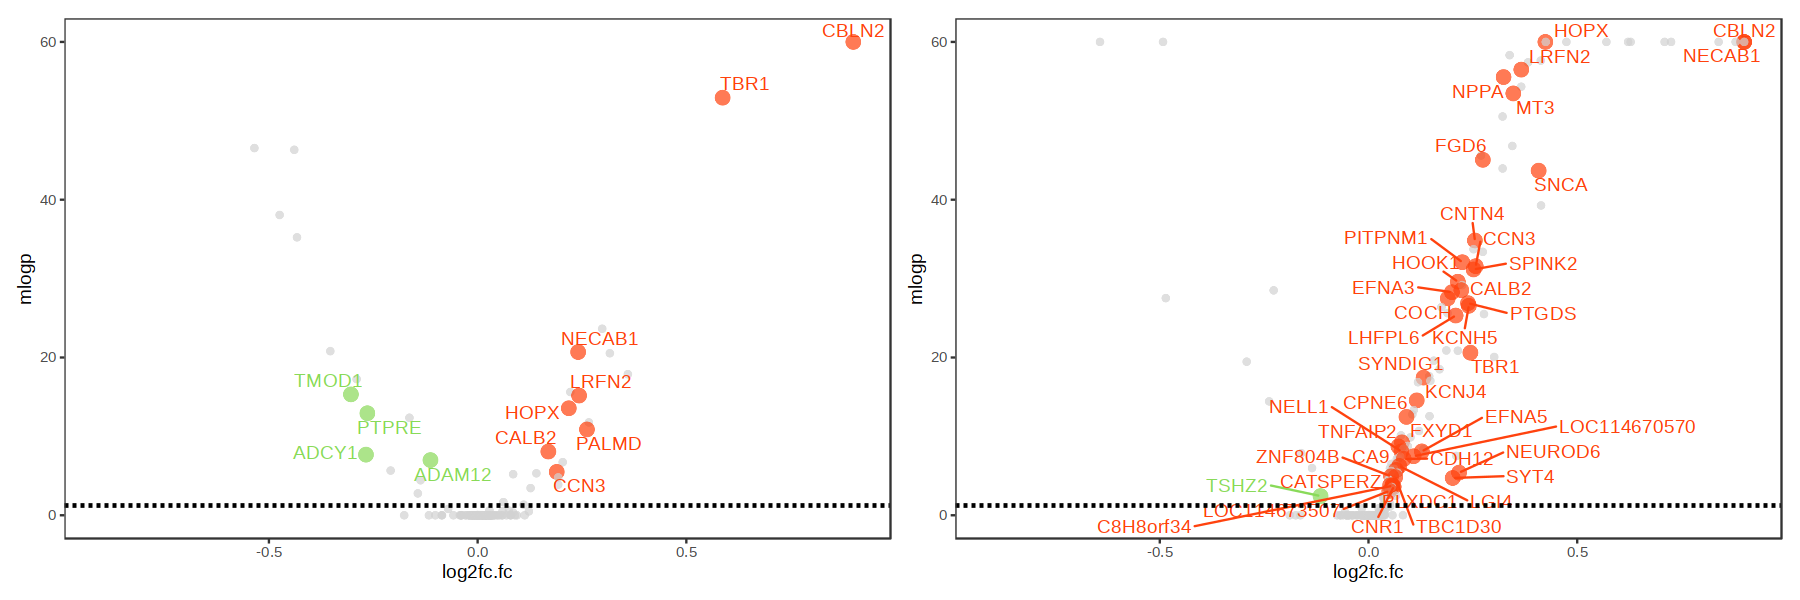

In [16]:
## volcano plot for early cells
## "upPALMD", 
plist2 <- lapply(c("upADRA2A", "upACTN2"), function(cls){
    subres <- deres[[cls]]
    ## region-specific genes to be labeled (show enrichment in vivo & also present as type2 genes in vitro)
    fc_label <- subres$gene[subres$p_val_adj <= 0.05 & subres$pct.fc >= 0.05 & subres$log2fc.fc > 0] %>% 
                    unique() %>%
                    intersect(., type2_genes[["FC"]])
    oc_label <- subres$gene[subres$p_val_adj <= 0.05 & subres$pct.oc >= 0.05 & subres$log2fc.oc > 0] %>% 
                    unique() %>%
                    intersect(., type2_genes[["OC"]])

    p <- PlotDot(data = subres, frontal_label = fc_label, occipital_label = oc_label,
                x_range = xaxis_limits, y_range = yaxis_limits)
    return(p)
    })
newp2 <- patchwork::wrap_plots(plist2, nrow = 1, ncol = length(plist2))
options(repr.plot.width=15, repr.plot.height=5)
newp2


In [17]:
## Validate some genes
fc.points <- rownames(submeta)[submeta$age %in% ag & 
                               submeta$period %in% "late" & 
                               submeta$region %in% "FC"]
oc.points <- rownames(submeta)[submeta$age %in% ag & 
                               submeta$period %in% "late" & 
                               submeta$region %in% "OC"]
## inconsistent regional enrichment between in vitro and in vivo
subrpkm[c("CBLN2", "TBR1", "NECAB1", "CALB2", "HOPX", "SNCA", "TMOD1", "ADCY1", "ADAM12", "TSHZ2"), 
        c(fc.points, oc.points)] 

,RM_8F_77,RM_9F_77,RM_10F_77,RM_8C_77,RM_9C_77,RM_10C_77
CBLN2,1.0184,1.0593,1.0049,0.0584,0.1020,0.0857
TBR1,0.9068,1.1747,1.0040,0.1392,0.2650,0.2024
NECAB1,10.3994,9.3361,7.4469,3.9371,4.1281,3.6987
CALB2,100.2505,125.4386,117.0243,55.6050,41.1125,40.6545
HOPX,128.4972,110.4658,156.3111,54.7800,60.0905,63.9759
SNCA,14.4201,16.6786,16.9895,4.8555,6.2506,7.0619
TMOD1,0.7723,0.8568,1.3890,1.9343,3.0700,4.0716
ADCY1,1.3786,1.5595,1.8477,4.8394,4.3963,4.5099
ADAM12,3.0038,4.0335,5.3086,7.0901,10.5585,11.9799
TSHZ2,0.0429,0.0890,0.0987,0.2822,0.3672,0.4951


Warning message:
“Removed 972 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 968 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 424 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 395 rows containing missing values (`geom_text_repel()`).”


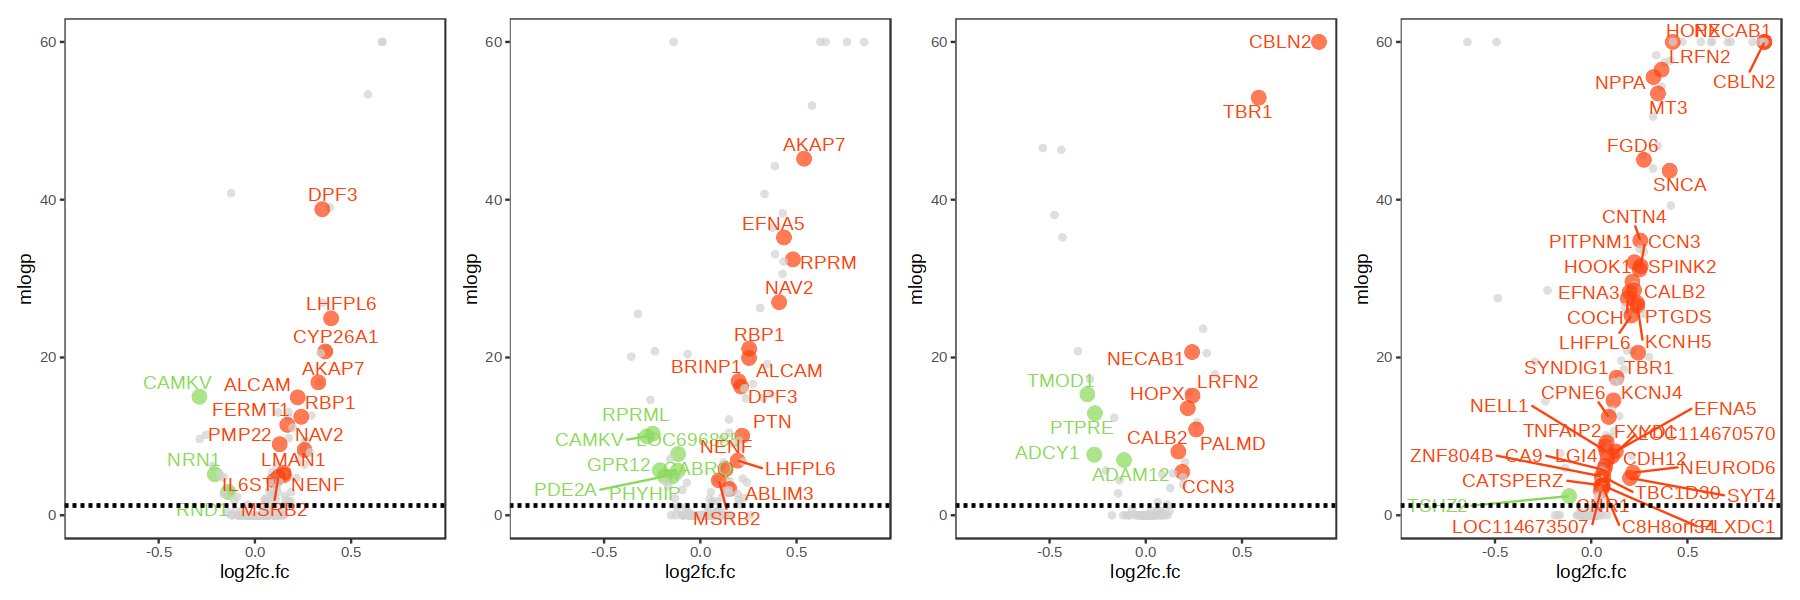

In [18]:
newp <- patchwork::wrap_plots(list(newp1, newp2), nrow = 1, ncol = 2, 
                              widths = c(0.1 * length(plist1), 0.1 * length(plist2)))
options(repr.plot.width=15, repr.plot.height=5)
newp

In [19]:
pdf(paste0("./report/Show_BulkDEG_in_vivo_combined_volcano_v3.pdf"), 
        width = 6*(length(plist1) + length(plist2)), height = 6, useDingbats = FALSE)
print(newp)
dev.off()

Warning message:
“Removed 972 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 968 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 424 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 395 rows containing missing values (`geom_text_repel()`).”


png 
  2

In [20]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-4.1.0/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-4.1.0/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.1      dplyr_1.1.0        SeuratObject_4.1.3 Seurat_4.3.0      

loaded via a namespace (and not attached):
  [1] ggbeeswarm_0.7.1       Rtsne_0.16             colorspace_2.0-